In [116]:
import pandas as pd
import seaborn as sns
from utils_init import *
import matplotlib.pyplot as plt
from utils_error_analysis import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from foodon_snomed_mappings import *
import numpy as np

In [2]:
#model_names =  ['bert','roberta','biobert','scibert']
#folds = range(0,10)
datasets=['cafeteria','hansard', 'foodon', 'snomedct']
#result_dir='results_10'
#fold_dir='folds_10'
#split='test'
#merged_all=get_merged_all(datasets, model_names, folds, result_dir, fold_dir, split)

In [3]:
def remove_I_B_prefix(df):
    dfr = df.copy()
    dfr['labels'] = dfr['labels'].apply(lambda x: x.replace('B-','').replace('I-',''))
    dfr['predictions']=dfr['predictions'].apply(lambda x: x.replace('B-','').replace('I-',''))
    return dfr

In [4]:
merged_all = pd.read_csv('merged_datasets_cafeteria_hansard_foodon_snomedct.csv', index_col=0)
merged_all = merged_all.pipe(remove_I_B_prefix)
merged_all

/opt/conda/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,words,predictions,sentence_id,word_id,labels,full sentence,fold,model_name,dataset
0,The,O,0.0,0,O,The nutritional value of gluten - free product...,0,bert,cafeteria
1,nutritional,O,0.0,1,O,The nutritional value of gluten - free product...,0,bert,cafeteria
2,value,O,0.0,2,O,The nutritional value of gluten - free product...,0,bert,cafeteria
3,of,O,0.0,3,O,The nutritional value of gluten - free product...,0,bert,cafeteria
4,gluten,B,0.0,4,B,The nutritional value of gluten - free product...,0,bert,cafeteria
...,...,...,...,...,...,...,...,...,...
13570,development,O,4598.0,14,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13571,of,O,4598.0,15,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13572,the,O,4598.0,16,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13573,disease,O,4598.0,17,O,Many environmental and genetic factors are sus...,9,scibert,snomedct


In [5]:
def filter_labels(df):
    labels_to_exclude=['O','macro avg','weighted avg','X','FOOD']
    return df.query("labels not in @labels_to_exclude and predictions not in @labels_to_exclude")

def get_top_n_worse_f1_labels(df, n=20):
    report = classification_report(df['labels'], df['predictions'], output_dict=True, zero_division=0)
    f1_scores = []
    for key in df['labels'].unique():
        f1_scores.append((report[key]['f1-score'], key))
    zip_list = sorted(f1_scores)
    return [x[1] for x in zip_list][:n]

In [15]:
hansard_mappings=pd.read_csv('ontology_mappings/hansard_pure.csv',index_col=[0])[['Semantic Tags','pure tag']].drop_duplicates()

In [119]:
dataset = 'hansard'
merged_dataset = merged_all.query("dataset == @dataset").pipe(filter_labels)
original_columns=merged_dataset.columns
merged_dataset=merged_dataset.merge(hansard_mappings, left_on='labels', how='left', right_on='pure tag')
merged_dataset['labels']=merged_dataset['Semantic Tags']
merged_dataset=merged_dataset[original_columns]
merged_dataset=merged_dataset.merge(hansard_mappings, left_on='predictions', how='left', right_on='pure tag')
merged_dataset['predictions']=merged_dataset['Semantic Tags']
merged_dataset=merged_dataset[original_columns].dropna()


/tmp/ipykernel_4111/1266934468.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  confusion.values[[np.arange(confusion.shape[0])]*2] = 0


(35, 10)
labels
AG.01.d.02 [Part/joint of animal]              1.000000
AG.01.d.04 [Mutton]                            1.000000
AG.01.n.03 [Puddings]                          1.000000
AG.01.n.12 [Pancake/tortilla/oatcake]          1.000000
AG.01.n.06 [Meat dishes]                       0.990000
AG.01.n.10 [Grain dishes]                      0.645669
AG.01.n.15 [Pastry]                            0.619048
AG.01.h.02.i [Herb]                            0.463415
AG.01.n.09 [Prepared vegetables and dishes]    0.467391
AG.01.aa [Aerated/carbonated drink]            0.529915
dtype: float64


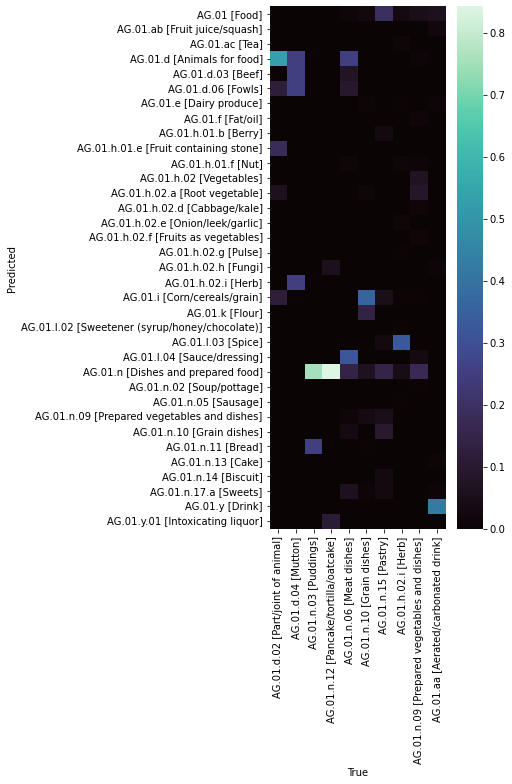

In [120]:

sorted_values = merged_dataset['labels'].sort_values().drop_duplicates()
confusion_np=confusion_matrix(merged_dataset['labels'], merged_dataset['predictions'], normalize='true', labels=sorted_values)
confusion=pd.DataFrame(confusion_np, columns=sorted_values, index=sorted_values)
confusion.values[[np.arange(confusion.shape[0])]*2] = 0    
keep_labels = get_top_n_worse_f1_labels(merged_dataset, n=10)
confusion = confusion.T[keep_labels]

confusion = confusion.loc[(confusion.sum(axis=1) != 0), :]
    
plt.figure(figsize=(7,11))
    
# Check if matplotlib didnt cut part of the matrix
print(confusion.shape)
# Sanity check. All columns have to sum to 1, othersize there is an error.
print(confusion.sum(axis=0))
    
    
sns.heatmap(data=confusion, cmap=sns.color_palette('mako', as_cmap=True))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig(f'visualizations/{dataset}_confusion.pdf')

In [7]:
# Sanity check if TRUE AG.01.ae get predicted as AG.01.ae
merged_dataset.query('labels=="AG.01.ae"')

,words,predictions,sentence_id,word_id,labels,full sentence,fold,model_name,dataset
203,malt,AG.01.e,468.0,7,AG.01.ae,"Other food ingredients , including starch , ma...",1,bert,hansard
4884,malt,AG.01.l.02,625.0,5,AG.01.ae,The use of alternatives to malt may affect the...,1,bert,hansard
4947,malted,AG.01.n.10,627.0,22,AG.01.ae,Research results have provided some new altern...,1,bert,hansard
4948,grains,AG.01.i,627.0,23,AG.01.ae,Research results have provided some new altern...,1,bert,hansard
203,malt,AG.01.l.01,468.0,7,AG.01.ae,"Other food ingredients , including starch , ma...",1,roberta,hansard
4884,malt,AG.01.l.01,625.0,5,AG.01.ae,The use of alternatives to malt may affect the...,1,roberta,hansard
4915,malt,AG.01.i,626.0,14,AG.01.ae,"Accordingly , the influential factors are disc...",1,roberta,hansard
4947,malted,AG.01.i,627.0,22,AG.01.ae,Research results have provided some new altern...,1,roberta,hansard
4948,grains,AG.01.i,627.0,23,AG.01.ae,Research results have provided some new altern...,1,roberta,hansard
203,malt,AG.01.i,468.0,7,AG.01.ae,"Other food ingredients , including starch , ma...",1,biobert,hansard


In [67]:
def remove_URL_foodon(df):
    dfr = df.copy()
    prefix = 'http://purl.obolibrary.org/obo/'
    dfr['labels'] = dfr['labels'].apply(lambda x: x.replace(prefix,''))
    dfr['predictions']=dfr['predictions'].apply(lambda x: x.replace(prefix,''))
    return dfr

def remove_URL_snomedct(df):
    dfr = df.copy()
    prefix = 'http://purl.bioontology.org/ontology/SNOMEDCT/'
    dfr['labels'] = dfr['labels'].apply(lambda x: x.replace(prefix,''))
    dfr['predictions']=dfr['predictions'].apply(lambda x: x.replace(prefix,''))
    return dfr

In [208]:
def process_foodon_tag_old(t,rows_or_columns):
    max_chars=35
    name=foodon_mappings[t]
    t=t.replace('FOODON_','F').replace('CHEBI_','C').replace('UBERON_','U').replace('NCBITaxon_','N')
    delimiter = "\n" if rows_or_columns=='columns' else " "
    t=t[:max_chars]+'...' if len(t)>max_chars else t
    name=name[:max_chars] + '...' if len(name)>max_chars else name
    name=f'{t}{delimiter}[{name}]'
    return name

def process_foodon_tag(t,rows_or_columns):
    max_chars=20
    snomed_name=foodon_mappings[t]
    if len(snomed_name) < max_chars:
        return snomed_name
    else:
        words=snomed_name.split(' ')
        return f'{" ".join(words[:3])}\n{" ".join(words[3:])}'

/tmp/ipykernel_4111/3216613154.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  confusion.values[[np.arange(confusion.shape[0])]*2] = 0


(11, 10)
labels
CHEBI_15377;FOODON_00002340;FOODON_00003496;NCBITaxon_3562;FOODON_03301716         1.0
CHEBI_16113                                                                        1.0
CHEBI_17992;FOODON_03301348;FOODON_03420108                                        1.0
CHEBI_18388                                                                        1.0
CHEBI_23044;FOODON_03304644                                                        1.0
CHEBI_24866;CHEBI_24866;CHEBI_26710;CHEBI_26710;FOODON_00001079;FOODON_03310311    1.0
CHEBI_24866;CHEBI_26710;CHEBI_15377;FOODON_00002340                                1.0
CHEBI_24866;CHEBI_26710;FOODON_00002158                                            1.0
CHEBI_24866;CHEBI_26710;FOODON_00003265;UBERON_0001013                             1.0
CHEBI_24866;CHEBI_26710;FOODON_00003265;UBERON_0001013;FOODON_03420108             1.0
dtype: float64
Index(['CHEBI_15377;FOODON_00002340', 'CHEBI_24866;CHEBI_26710',
       'CHEBI_24866;CHEBI_26710;FO

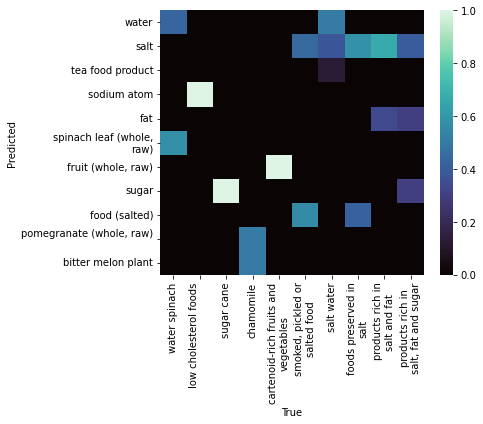

In [210]:
dataset = 'foodon'
merged_dataset = merged_all.query("dataset == @dataset").pipe(filter_labels).pipe(remove_URL_foodon)
sorted_values = merged_dataset['labels'].sort_values().drop_duplicates()
confusion_np=confusion_matrix(merged_dataset['labels'], merged_dataset['predictions'], normalize='true', labels=sorted_values)
confusion=pd.DataFrame(confusion_np, columns=sorted_values, index=sorted_values)
confusion.values[[np.arange(confusion.shape[0])]*2] = 0 
keep_labels = get_top_n_worse_f1_labels(merged_dataset, n=10)
confusion = confusion.T[keep_labels]
    
confusion = confusion.loc[(confusion.sum(axis=1) != 0), :]

# Set this to 5,9 when labels are fixed
plt.figure(figsize=(7,6))
    
# Check if matplotlib didnt cut part of the matrix
print(confusion.shape)
# Sanity check. All columns have to sum to 1, othersize there is an error.
print(confusion.sum(axis=0))
print(confusion.index)
confusion.index=[process_foodon_tag(x,'rows') for x in confusion.index]
confusion.columns=[process_foodon_tag(x,'columns') for x in confusion.columns]

sns.heatmap(data=confusion, cmap=sns.color_palette('mako', as_cmap=True))

plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig(f'visualizations/{dataset}_confusion.pdf')

In [193]:
def process_snomed(t,rows_or_columns):
    max_chars=30
    snomed_name=snomed_ct_mappings[t]
    if len(snomed_name) < max_chars:
        return snomed_name
    else:
        return snomed_name[:max_chars]+'\n' +  snomed_name[max_chars:]
    t=t.replace('http://purl.bioontology.org/ontology/SNOMEDCT/','')
    delimiter = "\n" if rows_or_columns=='columns' else " "
    t=t[:max_chars]+'...' if len(t)>max_chars else t
    snomed_name=snomed_name[:max_chars] + '...' if len(snomed_name)>max_chars else snomed_name
    snomed_name=f'{t}{delimiter}[{snomed_name}]'
    return snomed_name # 
  

/tmp/ipykernel_4111/301518729.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  confusion.values[[np.arange(confusion.shape[0])]*2] = 0


(30, 10)
labels
http://purl.bioontology.org/ontology/SNOMEDCT/102261002;http://purl.bioontology.org/ontology/SNOMEDCT/227418000;http://purl.bioontology.org/ontology/SNOMEDCT/735051003                                                           1.0
http://purl.bioontology.org/ontology/SNOMEDCT/102261002;http://purl.bioontology.org/ontology/SNOMEDCT/227601008                                                                                                                   1.0
http://purl.bioontology.org/ontology/SNOMEDCT/102262009;http://purl.bioontology.org/ontology/SNOMEDCT/227708009;http://purl.bioontology.org/ontology/SNOMEDCT/255621006                                                           1.0
http://purl.bioontology.org/ontology/SNOMEDCT/102262009;http://purl.bioontology.org/ontology/SNOMEDCT/230118003                                                                                                                   1.0
http://purl.bioontology.org/ontology/SNOMEDCT/129561006;http://p

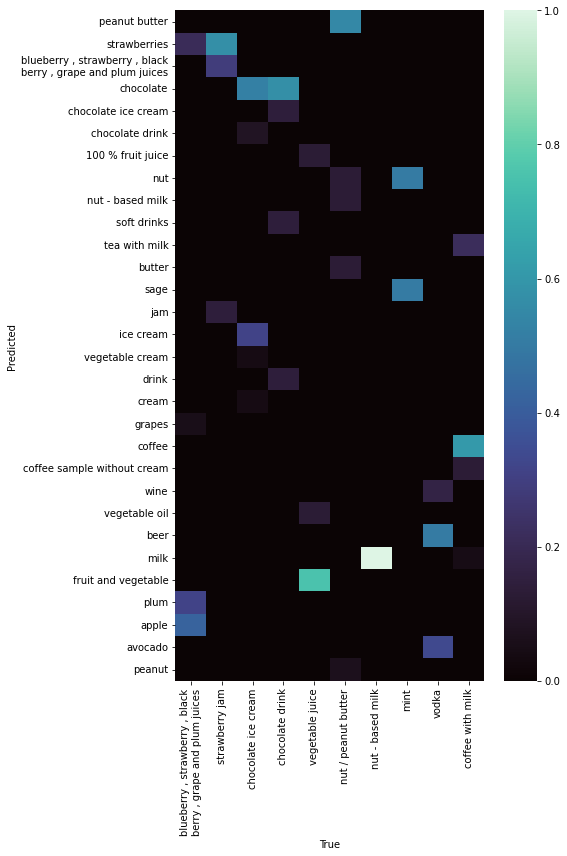

In [207]:
dataset = 'snomedct'
merged_dataset = merged_all.query("dataset == @dataset").pipe(filter_labels)#.pipe(remove_URL_snomedct)
sorted_values = merged_dataset['labels'].sort_values().drop_duplicates()
confusion_np=confusion_matrix(merged_dataset['labels'], merged_dataset['predictions'], normalize='true', labels=sorted_values)
confusion=pd.DataFrame(confusion_np, columns=sorted_values, index=sorted_values)
confusion.values[[np.arange(confusion.shape[0])]*2] = 0 
keep_labels = get_top_n_worse_f1_labels(merged_dataset, n=10)
confusion = confusion.T[keep_labels]
    
confusion = confusion.loc[(confusion.sum(axis=1) != 0), :]

# Set this to 5,9 when labels are fixed
plt.figure(figsize=(8,12))
    
# Check if matplotlib didnt cut part of the matrix
print(confusion.shape)
# Sanity check. All columns have to sum to 1, othersize there is an error.
print(confusion.sum(axis=0))

confusion.index=[process_snomed(x, 'rows') for x in confusion.index]
confusion.columns=[process_snomed(x, 'columns') for x in confusion.columns]

sns.heatmap(data=confusion, cmap=sns.color_palette('mako', as_cmap=True))

plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig(f'visualizations/{dataset}_confusion.pdf')